In [ ]:
!pip install transformers
!pip install tqdm
!pip install scipy
!pip install torch
!pip install tensorflow
!pip install flax
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

plt.style.use('ggplot')

import nltk

In [ ]:
# Read in data
df = pd.read_csv("E:\AWS GP\ProcessedPositiveRealTimeTweets.csv")
print(df.shape)
df = df.head(500)
print(df.shape)

(1187, 4)
(500, 4)


In [ ]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Text cleaning function with handling for non-string input
def clean_text(text):
    if isinstance(text, str):  # Ensure that the text is a string
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    else:
        return ''  # Return an empty string for non-string entries

# Apply cleaning
# Check if 'text' column exists, if not, use 'Text'
if 'text' in df.columns:
    df['cleaned_text'] = df['text'].apply(clean_text)
else:
    df['cleaned_text'] = df['Text'].apply(clean_text)

# Create a new DataFrame with only the cleaned_text column
cleaned_df = df[['cleaned_text']]

# Save the cleaned text to a new CSV file
cleaned_df.to_csv('cleaned_tweets.csv', index=False)


In [ ]:
df.head()

,tweet_id,text,timestamp,sentiment,cleaned_text
0,1,An inspiration in all aspects: Fashion,2024-10-15 6:43:12,positive,inspiration aspect fashion
1,2,beauty and personality. :)KISSES TheFashionIcon,2024-10-15 6:38:12,positive,beauty personality KISSES thefashionicon
2,3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,2024-10-15 6:33:12,positive,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...
3,4,Beautiful album from the greatest unsung guit...,2024-10-15 6:28:12,positive,beautiful album great unsung guitar genius t...
4,5,Good luck to Rich riding for great project in ...,2024-10-15 6:23:12,positive,good luck Rich ride great project Sunday donate


In [ ]:
cleaned_df.head()

,cleaned_text
0,inspiration aspect fashion
1,beauty personality KISSES thefashionicon
2,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...
3,beautiful album great unsung guitar genius t...
4,good luck Rich ride great project Sunday donate


In [ ]:
example = df['text'][50]
print(example)

she might have dressed a bit better.


In [ ]:
# Download the 'punkt' resource
nltk.download('punkt')

# Now you can proceed with tokenization
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to C:\Users\Adnan
[nltk_data]     Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['she', 'might', 'have', 'dressed', 'a', 'bit', 'better', '.']

In [ ]:
# Download the 'averaged_perceptron_tagger' resource
nltk.download('averaged_perceptron_tagger')

# Now you can proceed with part-of-speech tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Adnan Mohamed\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('she', 'PRP'),
 ('might', 'MD'),
 ('have', 'VB'),
 ('dressed', 'VBN'),
 ('a', 'DT'),
 ('bit', 'NN'),
 ('better', 'RBR'),
 ('.', '.')]

In [ ]:
cleaned_example = df['cleaned_text'][50]
print(cleaned_example)

dress bit well


In [ ]:
# Now you can proceed with tokenization
cleaned_tokens = nltk.word_tokenize(cleaned_example)
cleaned_tokens[:10]

['dress', 'bit', 'well']

In [ ]:
# Now you can proceed with part-of-speech tagging
cleaned_tagged = nltk.pos_tag(cleaned_tokens)
cleaned_tagged[:10]

[('dress', 'NN'), ('bit', 'NN'), ('well', 'RB')]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Run for Roberta Model
print(example)
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

she might have dressed a bit better.
{'roberta_neg': 0.06885914, 'roberta_neu': 0.71926785, 'roberta_pos': 0.21187301}


In [ ]:
# Run for Roberta Model
print(cleaned_example)
cleaned_encoded_text = tokenizer(cleaned_example, return_tensors='pt')
cleaned_output = model(**cleaned_encoded_text)
cleaned_scores = cleaned_output[0][0].detach().numpy()
cleaned_scores = softmax(cleaned_scores)
cleaned_scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(cleaned_scores_dict)

dress bit well
{'roberta_neg': 0.06885914, 'roberta_neu': 0.71926785, 'roberta_pos': 0.21187301}


In [ ]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['tweet_id']
        res[myid] = polarity_scores_roberta(text) # Call the defined function
    except ValueError:
        print(f'Broke for id {myid}')

 44%|███████████████████████████████████▌                                            | 222/500 [00:45<00:47,  5.90it/s]

Broke for id 223


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:38<00:00,  5.09it/s]


In [ ]:
roberta_df = pd.DataFrame(res).T
print(roberta_df)
roberta_df = roberta_df.reset_index().rename(columns={'index': 'tweet_id'})
roberta_df = roberta_df.merge(df, how='left')

     roberta_neg  roberta_neu  roberta_pos
1       0.004537     0.289679     0.705783
2       0.001549     0.082718     0.915733
3       0.004962     0.457639     0.537399
4       0.001914     0.021464     0.976622
5       0.001049     0.023035     0.975915
..           ...          ...          ...
496     0.146129     0.777251     0.076620
497     0.003147     0.029146     0.967707
498     0.002836     0.182760     0.814405
499     0.151908     0.715632     0.132460
500     0.603364     0.373431     0.023205

[499 rows x 3 columns]


In [ ]:
# Now we have sentiment score and metadata
roberta_df.head()

,tweet_id,roberta_neg,roberta_neu,roberta_pos,text,timestamp,sentiment,cleaned_text
0,1,0.004537,0.289679,0.705783,An inspiration in all aspects: Fashion,2024-10-15 6:43:12,positive,inspiration aspect fashion
1,2,0.001549,0.082718,0.915733,beauty and personality. :)KISSES TheFashionIcon,2024-10-15 6:38:12,positive,beauty personality KISSES thefashionicon
2,3,0.004962,0.457639,0.537399,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,2024-10-15 6:33:12,positive,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...
3,4,0.001914,0.021464,0.976622,Beautiful album from the greatest unsung guit...,2024-10-15 6:28:12,positive,beautiful album great unsung guitar genius t...
4,5,0.001049,0.023035,0.975915,Good luck to Rich riding for great project in ...,2024-10-15 6:23:12,positive,good luck Rich ride great project Sunday donate


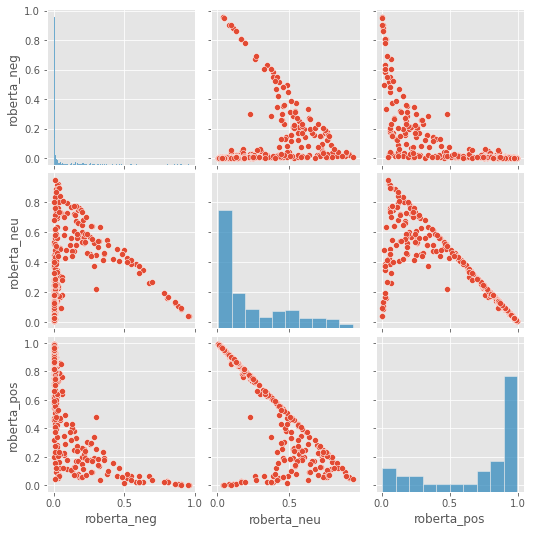

In [ ]:
sns.pairplot(data=roberta_df,
             vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            palette='tab10')
plt.show()

#Using pipline

In [ ]:
# !pip install tf-keras

from transformers import pipeline

custom_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline('I Hate sentiment analysis!')

[{'label': 'NEGATIVE', 'score': 0.9992958307266235}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

Real Time Sentiment Analysis Pipline


In [ ]:
import time

# Load the dataset (assuming it's in CSV format)
dataset = pd.read_csv('E:\AWS GP\ProcessedNeutralRealTimeTweets.csv')

# Simulate real-time streaming
for index, row in dataset.iterrows():
    tweet_data = {
        'tweet_id': row['tweet_id'],
        'text': row['text'],
        'timestamp': row['timestamp']
    }

    print(f"tweet : {tweet_data['text']} : {sent_pipeline(tweet_data['text'])}")

    # Simulate a delay between tweets (e.g., 1 second)
    time.sleep(1)

    if tweet_data['tweet_id'] == 20:
        break

tweet : Pak PM survives removal scare : [{'label': 'NEGATIVE', 'score': 0.5376164317131042}]
tweet : but court orders further probe into corruption charge. : [{'label': 'NEGATIVE', 'score': 0.9725276231765747}]
tweet : Supreme Court quashes criminal complaint against cricketer for allegedly depicting himself as on magazine cover. : [{'label': 'NEGATIVE', 'score': 0.9688304662704468}]
tweet : Art of Living's fights back over Yamuna floodplain damage : [{'label': 'NEGATIVE', 'score': 0.8536454439163208}]
tweet : livid. : [{'label': 'NEGATIVE', 'score': 0.9814456105232239}]
tweet : FCRA slap on NGO for lobbying...But was it doing so as part of govt campaign? : [{'label': 'NEGATIVE', 'score': 0.9989498257637024}]
tweet : Why doctors : [{'label': 'NEGATIVE', 'score': 0.9627422094345093}]
tweet : pharma companies are opposing names on : [{'label': 'NEGATIVE', 'score': 0.9973390698432922}]
tweet : Why a bicycle and not a CM asked. His officer learnt ground reality -- and  a dip in a river. : 

KeyboardInterrupt: 

In [ ]:
import time

# Load the dataset (assuming it's in CSV format)
#dataset = pd.read_csv('/content/ProcessedPositiveRealTimeTweets.csv')
dataset = pd.read_csv("E:\AWS GP\GProject in AWS sagemaker\sentimentdataset.csv")

i=0

# Simulate real-time streaming
for index, row in dataset.iterrows():
    try:
        tweet_data = {
            'text': row['text']
        }

        print(f"tweet : {tweet_data['text']} : {sent_pipeline(tweet_data['text'])}")

        i+=1

        # Simulate a delay between tweets (e.g., 1 second)
        time.sleep(1)

        if i == 20:
            break # Indent this line to be within the 'if' block
    except ValueError:
        print(f'Broken tweet ValueError: {tweet_data["text"]}')

tweet :  Enjoying a beautiful day at the park!               : [{'label': 'POSITIVE', 'score': 0.9998897314071655}]
tweet :  Traffic was terrible this morning.                  : [{'label': 'NEGATIVE', 'score': 0.9988304972648621}]
tweet :  Just finished an amazing workout! 💪                : [{'label': 'POSITIVE', 'score': 0.9991503953933716}]
tweet :  Excited about the upcoming weekend getaway!         : [{'label': 'POSITIVE', 'score': 0.9996711015701294}]
tweet :  Trying out a new recipe for dinner tonight.         : [{'label': 'NEGATIVE', 'score': 0.8354264497756958}]
tweet :  Feeling grateful for the little things in life.     : [{'label': 'POSITIVE', 'score': 0.9997934699058533}]
tweet :  Rainy days call for cozy blankets and hot cocoa.    : [{'label': 'NEGATIVE', 'score': 0.7110623121261597}]
tweet :  The new movie release is a must-watch!              : [{'label': 'POSITIVE', 'score': 0.9998325109481812}]
tweet :  Political discussions heating up on the timeline.   : [{'label':